## Setup: Imports and (Optional) Mount to google drive
In a production setting, our pipeline downloads data programmatically
 from the ISIC API at runtime. However, to avoid re-downloading the entire
       dataset every time a Colab session restarts, we instead mount Google Drive here and read the cached files directly.
       

In [1]:
# Import Drive
from google.colab import output
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard library
import os
import time
import random

# Data handling
import requests
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

# PyTorch & vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import timm
import torchvision.transforms as transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn


# Scikit-learn metrics & utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    precision_recall_curve,
    confusion_matrix
)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


Set a fixed random seed to ensure reproducible training and evaluation results across runs.


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Data Acquisition & Exploration
- Download raw images and metadata from the ISIC API  
- Inspect dataset structure and class distribution  


Load the dataset ISIC(collection 66, representative of the training set of task 3) into the *results* variable, ~11k entries

In [4]:
base_url = "https://api.isic-archive.com/api/v2/images/search/"
params = {
    "collections": "66,67,73"
}

all_ids = []
results = []

page = 1
start = time.time()

while True:
    response = requests.get(base_url, params=params)
    data = response.json()

    # Extract image IDs
    for result in data.get("results", []):
        all_ids.append(result["isic_id"])
        results.append(result)

    # Next page
    next_cursor = data.get("next")
    if not next_cursor:
        break

    # Update URL for the next request
    base_url = next_cursor
    params = {}
    page += 1

elapsed = time.time() - start
print(f"Total images collected: {len(all_ids)}")
print(f"Took {elapsed:.1f} seconds")

Total images collected: 11720
Took 70.4 seconds


Inspecting a single record to understand its structure and contents

In [5]:
results[5]

{'isic_id': 'ISIC_0036059',
 'copyright_license': 'CC-BY-NC',
 'attribution': 'MILK study team',
 'files': {'full': {'url': 'https://content.isic-archive.com/b1da82d9-f96a-4279-a22d-4df086f862e8/ab106229-0d37-440d-82e1-ea0f8b346576.jpg?Expires=1747699200&Signature=mzMbG9xwAx-zNndbjTADysTngWZ3zFNvm8URkiuB9ffk3UMPDBDZmS0c3T197t9i~SFTKMFhuiQBS2ldMI3dqvHxPhPt~K8eTZQ64XOu5niqS-XFH03IUFbf8LYjc6Fgs~One-I1LxNlR8Nu9U14CMlPSw4T~SsCEhfoAfyDIpU~newXnuk6Uxja5ZGYjN9SL4ELiNfVd6WBJOKtl-mqv~f47wq-Yql~0hynJef77s2dWJKzUJvuWOHEq1wxYoBfRCN4oGU4CblwoiB5NiAgp27TfTC5jxbdfxYQ--h97wHApI~V6Yfewlrs3xPNxj252JuVbFG6qwV6owGomSYlQw__&Key-Pair-Id=K3KFHCM130RXTL',
   'size': 19565},
  'thumbnail_256': {'url': 'https://content.isic-archive.com/8430b64f-83c0-4f66-98ab-260535ab538c/ISIC_0036059_thumbnail_256.jpg?Expires=1747699200&Signature=dEjiLGv7gTz~waFAE22xn3IZNZnXsZfeMqc9wDKXdtU7ztCPvLDFnrHgxeXohkzC-Mp8FW1-nFIOLcee8psBNCz7Kz1YZD1NejrsCB7o8oqnR~2lBYk91NlxhLjEpiNzYPcaNbCdT7tJ0MY5ohoLv65OSXFT6WDXtVp~rJPZgfsouan700Vjvv63

**We will confirm if every image is in the expected size (600x450)**

In [6]:
# Verify that all images are 600×450 pixels(Expected size)
mismatch_count = 0

for entry in results:
    try:
        x = entry["metadata"]["acquisition"]["pixels_x"]
        y = entry["metadata"]["acquisition"]["pixels_y"]
        if (x, y) != (600, 450):
            print(f"Image {entry['isic_id']} has size {x}×{y}, expected 600×450")
            mismatch_count += 1
    except KeyError:
        print(f"Image {entry.get('isic_id', 'UNKNOWN')} is missing pixel metadata.")
        mismatch_count += 1

if mismatch_count == 0:
    print("All images are confirmed to be 600×450 pixels.")
else:
    print(f"Found {mismatch_count} image(s) with unexpected dimensions or missing data.")


All images are confirmed to be 600×450 pixels.


Download the photos into ISIC_IMAGES_TASK_3 folder. By default the path searches for the files in drive.

In [7]:
PATH = "/content/drive/MyDrive/ISIC_IMAGES_TASK_3"

In [8]:
"""
#Download and extract ZIP files into ISIC_IMAGES_TASK_3 folder with timing

import os
import zipfile
import urllib.request
import time

# Start timing
total_start = time.time()

# Target folder
PATH = "ISIC_IMAGES_TASK_3"
os.makedirs(PATH, exist_ok=True)

# Base URL for raw GitHub content
base_url = "https://github.com/PedroDiz/AP-2025/raw/main/"

# List of ZIP file names
zip_files = [
    "ISIC_IMAGES_TASK_3_PART_1.zip",
    "ISIC_IMAGES_TASK_3_PART_2.zip",
    "ISIC_IMAGES_TASK_3_PART_3.zip"
]

# Download and extract each ZIP file
for zip_file in zip_files:
    start = time.time()

    zip_path = os.path.join(os.getcwd(), zip_file)
    url = base_url + zip_file

    # Download if not already present
    if not os.path.exists(zip_path):
        print(f"Downloading {zip_file}...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Downloaded {zip_file} in {time.time() - start:.1f} seconds")
    else:
        print(f"{zip_file} already exists, skipping download")

    # Extract into PATH
    print(f"Extracting {zip_file}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(PATH)
    print(f"Extracted {zip_file} in {time.time() - start:.1f} seconds")

# Total elapsed time
total_elapsed = time.time() - total_start
print(f"\nTotal time: {total_elapsed:.1f} seconds")"""

'\n#Download and extract ZIP files into ISIC_IMAGES_TASK_3 folder with timing\n\nimport os\nimport zipfile\nimport urllib.request\nimport time\n\n# Start timing\ntotal_start = time.time()\n\n# Target folder\nPATH = "ISIC_IMAGES_TASK_3"\nos.makedirs(PATH, exist_ok=True)\n\n# Base URL for raw GitHub content\nbase_url = "https://github.com/PedroDiz/AP-2025/raw/main/"\n\n# List of ZIP file names\nzip_files = [\n    "ISIC_IMAGES_TASK_3_PART_1.zip",\n    "ISIC_IMAGES_TASK_3_PART_2.zip",\n    "ISIC_IMAGES_TASK_3_PART_3.zip"\n]\n\n# Download and extract each ZIP file\nfor zip_file in zip_files:\n    start = time.time()\n\n    zip_path = os.path.join(os.getcwd(), zip_file)\n    url = base_url + zip_file\n\n    # Download if not already present\n    if not os.path.exists(zip_path):\n        print(f"Downloading {zip_file}...")\n        urllib.request.urlretrieve(url, zip_path)\n        print(f"Downloaded {zip_file} in {time.time() - start:.1f} seconds")\n    else:\n        print(f"{zip_file} alre

In [9]:
"""
import os
import requests
import time
from tqdm import tqdm

# Make sure the folder exists
PATH = "ISIC_IMAGES_TASK_3"
os.makedirs(PATH, exist_ok=True)

# Start the timer
download_start = time.time()

# Optionally, to capture per‐image times:
per_image_times = []

for result in tqdm(results, desc="Downloading ISIC images"):
    img_start = time.time()
    try:
        isic_id   = result["isic_id"]
        image_url = result["files"]["full"]["url"]
        file_path = os.path.join(PATH, f"{isic_id}.jpg")

        # Download and save the image
        r = requests.get(image_url)
        if r.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(r.content)
        else:
            print(f"Failed to download {isic_id}: HTTP {r.status_code}")
    except KeyError as e:
        print(f"Missing key {e} in one of the results.")
    finally:
        # Record how long this single download took
        per_image_times.append(time.time() - img_start)

# Total download time
total_download_time = time.time() - download_start
print(f"Total download time: {total_download_time:.1f}s")

# Per‐image times:
print(f"Avg per‐image download time: {np.mean(per_image_times):.2f}s")
print(f"Slowest image took: {np.max(per_image_times):.2f}s")
print(f"Fastest image took: {np.min(per_image_times):.2f}s")

"""

'\nimport os\nimport requests\nimport time\nfrom tqdm import tqdm\n\n# Make sure the folder exists\nPATH = "ISIC_IMAGES_TASK_3"\nos.makedirs(PATH, exist_ok=True)\n\n# Start the timer\ndownload_start = time.time()\n\n# Optionally, to capture per‐image times:\nper_image_times = []\n\nfor result in tqdm(results, desc="Downloading ISIC images"):\n    img_start = time.time()\n    try:\n        isic_id   = result["isic_id"]\n        image_url = result["files"]["full"]["url"]\n        file_path = os.path.join(PATH, f"{isic_id}.jpg")\n\n        # Download and save the image\n        r = requests.get(image_url)\n        if r.status_code == 200:\n            with open(file_path, "wb") as f:\n                f.write(r.content)\n        else:\n            print(f"Failed to download {isic_id}: HTTP {r.status_code}")\n    except KeyError as e:\n        print(f"Missing key {e} in one of the results.")\n    finally:\n        # Record how long this single download took\n        per_image_times.append(t

**Determine how each image is labeled as benign or malignant.**

We’ll use the `benign_malignant` field for this purpose and first verify that every dataset entry includes this label.


In [10]:
# List unique values for 'benign_malignant' and count missing entries
unique_vals = set()
missing_count = 0

for entry in results:
    clinical = entry.get("metadata", {}).get("clinical", {})
    val = clinical.get("benign_malignant", None)
    if val is None:
        missing_count += 1
    else:
        unique_vals.add(val)

# Print the unique labels found
if unique_vals:
    print(f"Unique 'benign_malignant' values: {', '.join(sorted(unique_vals))}")
else:
    print("No entries possess the 'benign_malignant' parameter.")

# Report how many are missing
if missing_count > 0:
    print(f"{missing_count} entries do not possess the 'benign_malignant' parameter.")


Unique 'benign_malignant' values: benign, malignant
2678 entries do not possess the 'benign_malignant' parameter.


**Summary:** A number of records are missing the `benign_malignant` attribute, so we must select an alternative field. The `diagnosis_1` attribute appears suitable for this task; next, we will examine its possible values.


In [11]:
missing_diagnosis_1_values = set()

for entry in results:
    clinical = entry.get("metadata", {}).get("clinical", {})

    if "benign_malignant" not in clinical:
        diag1 = clinical.get("diagnosis_1")
        if diag1:
            missing_diagnosis_1_values.add(diag1)

print(" Unique 'diagnosis_1' values for entries missing 'benign_malignant':")
for value in sorted(missing_diagnosis_1_values):
    print("-", value)


 Unique 'diagnosis_1' values for entries missing 'benign_malignant':
- Benign
- Indeterminate
- Malignant


**Conclusion:** For records lacking the `benign_malignant` attribute, we will use `diagnosis_1`, which also indicates lesion pathology. Entries where `diagnosis_1` equals “Indeterminate” will be excluded, as they do not provide definitive diagnostic information.


We will construct `lesions.csv` with the following columns:

- **file**: `<isic_id>.jpg`  
- **patient**: `lesion_id`  
- **label**:  
  - `0` for records where `benign_malignant == "benign"`  
  - `1` for records where `benign_malignant == "malignant"`  







In [12]:
rows = []
start = time.time()
for result in results:
    try:
        isic_id = result["isic_id"]
        filename = f"{isic_id}.jpg"
        clinical = result["metadata"]["clinical"]
        patient = clinical.get("lesion_id", "unknown")

        benign_malignant = clinical.get("benign_malignant")
        diagnosis_1 = clinical.get("diagnosis_1", "")

        if benign_malignant:
            label = 1 if benign_malignant.lower() == "malignant" else 0
        elif diagnosis_1 == "Benign":
            label = 0
        elif diagnosis_1 == "Malignant":
            label = 1
        else:  # Indeterminate or unknown
            continue

        rows.append({
            "file": filename,
            "patient": patient,
            "label": label
        })

    except Exception as e:
        print(f"Skipped entry {result.get('isic_id', 'UNKNOWN')} due to error: {e}")

df = pd.DataFrame(rows)
df.to_csv("lesions.csv", index=False)

elapsed = time.time() - start
print(f"Took {elapsed:.1f} seconds")

print("Saved lesions.csv with", len(df), "entries.")


Took 0.1 seconds
Saved lesions.csv with 11571 entries.


# Data Split & Preprocessing




**Patient‐wise 70/15/15 split:**  
We randomly assign 70 % of patients to training and split the remaining 30 % equally into validation and test sets, filter the DataFrame accordingly, save each subset to CSV, and confirm sample counts and an overall 81 %/19 % benign/malignant distribution.  

In [13]:
df = pd.read_csv("lesions.csv")

unique_patients = df["patient"].unique()

train_patients, temp_patients = train_test_split(
    unique_patients, test_size=0.30, random_state=42
)

# Split temp → 50/50 into val and test (15% each)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

# Create splits by filtering on patient ID
train_df = df[df["patient"].isin(train_patients)].reset_index(drop=True)
val_df = df[df["patient"].isin(val_patients)].reset_index(drop=True)
test_df = df[df["patient"].isin(test_patients)].reset_index(drop=True)

train_df.to_csv("lesions_train.csv", index=False)
val_df.to_csv("lesions_val.csv", index=False)
test_df.to_csv("lesions_test.csv", index=False)

print(f"Train: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")

label_counts = df["label"].value_counts(normalize=True) * 100
print(f"Overall dataset class distribution:")
print(f"  Benign  (0): {label_counts.get(0, 0):.2f}%")
print(f"  Malignant (1): {label_counts.get(1, 0):.2f}%")


Train: 8134 samples
Val:   1694 samples
Test:  1743 samples
Overall dataset class distribution:
  Benign  (0): 81.37%
  Malignant (1): 18.63%


Augmentation and pre-processing

In [14]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])

])

val_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                         [0.5,0.5,0.5])
])


# Dataset & Dataloaders

This custom `SkinCancerDataset` class wraps our image DataFrame for PyTorch:

- **`dataframe`**: Pandas DataFrame containing `file`, `patient`, and `label` columns.  
- **`image_dir`**: Directory where the images (`<isic_id>.jpg`) are stored.  
- **`transform`**: A `torchvision.transforms.Compose` object for preprocessing and (optionally) augmentations.  
- **`return_filename`**: If `True`, `__getitem__` returns `(image, label, filename)`, useful for logging .

In [15]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, return_filename=False):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.return_filename = return_filename

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["file"])
        label = torch.tensor(row["label"], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.return_filename:
            return image, label, row["file"]
        else:
            return image, label

Wrap `SkinCancerDataset` in a PyTorch `DataLoader`

In [16]:
"""# 2) Instantiate the training dataset & loader
train_dataset = SkinCancerDataset(
    train_df,
    PATH,
    transform=train_transform,
    return_filename=False
)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,      # Uniform sampling each epoch
    num_workers=2
)

# 3) Instantiate the validation dataset & loader
val_dataset = SkinCancerDataset(
    val_df,
    PATH,
    transform=val_transform,
    return_filename=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)
"""

# Cell: Training & Validation DataLoaders with 70% Benign / 30% Malignant Sampling

train_dataset = SkinCancerDataset(
    train_df,
    PATH,
    transform=train_transform,
    return_filename=False
)

#Sample weights for a 70/30 benign/malignant mix
p_m = train_df["label"].mean()   # e.g. ~0.12
w_benign    = 0.7 / (1.0 - p_m)
w_malignant = 0.3 / p_m

sample_weights = train_df["label"].map({
    0: w_benign,      # benign weight
    1: w_malignant    # malignant weight
}).values

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Train DataLoader using the sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

# Validation DataLoader (unchanged)
val_dataset = SkinCancerDataset(
    val_df,
    PATH,
    transform=val_transform,
    return_filename=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)



# Model, Loss, Optimizer & Scheduler

Instantiate a pretrained EfficientNet-B0 model with a single output neuron for binary (benign vs. malignant) classification.  

In [50]:

model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=1  # output neuron
)
"""
model = timm.create_model(
    "convnext_tiny",
    pretrained=True,
    nu<m_classes=1
)"""

'\nmodel = timm.create_model(\n    "convnext_tiny",      \n    pretrained=True,\n    nu<m_classes=1\n)'

Focal Binary Cross‐Entropy (Focal BCE) loss down‐weights easy examples and focuses training on hard, misclassified samples.







In [51]:
class FocalBCELoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=0.5, reduction="mean", use_focal=True):
        """
        alpha: weight for the positive (malignant) class (0 < alpha < 1)
               smaller alpha → less emphasis on positives
        gamma: focusing parameter (≥0), smaller → less focus on hard examples
        reduction: 'mean' or 'sum'
        use_focal: if False, falls back to plain BCEWithLogitsLoss
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.use_focal = use_focal

        if self.use_focal:
            # keep one BCE-with-logits loss per example for focal computation
            self.bce = nn.BCEWithLogitsLoss(reduction='none')
        else:
            # if not using focal, just use standard BCEWithLogitsLoss with reduction
            self.bce = nn.BCEWithLogitsLoss(reduction=self.reduction)

    def forward(self, logits, targets):
        # logits: raw model outputs (no sigmoid), shape [batch_size]
        # targets: ground-truth labels (0.0 or 1.0), shape [batch_size]

        if not self.use_focal:
            # simple binary cross-entropy on logits
            return self.bce(logits, targets)

        # 1. Compute per-example BCE loss (no reduction)
        bce_loss = self.bce(logits, targets)  # shape [batch_size]

        # 2. Convert logits to probabilities in [0,1]
        prob = torch.sigmoid(logits)          # shape [batch_size]

        # 3. p_t: model's probability of the true class
        #    for positive: prob; for negative: 1 - prob
        p_t = prob * targets + (1 - prob) * (1 - targets)

        # 4. alpha factor: alpha for positives, (1 - alpha) for negatives
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # 5. focal factor: (1 - p_t)^gamma — focuses on hard (uncertain) examples
        focal_factor = (1 - p_t) ** self.gamma

        # 6. Combine: alpha * focal * bce
        loss = alpha_factor * focal_factor * bce_loss  # shape [batch_size]

        # 7. Reduce to scalar
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss  # return per-example losses if reduction is None


**Training configuration:**  
- **Loss:** Focal Binary Cross‐Entropy.  
- **Optimizer:** AdamW (learning rate = 3e-4, weight decay = 1e-4).  
- **LR Scheduler:** Cosine annealing over 30 epochs (`T_max=30`).  


In [52]:

criterion = FocalBCELoss(gamma=1.5,alpha=0.7)
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)


# Training & Validation Helper Functions

In [53]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2



def apply_mixup_or_cutmix(x, y, alpha=0.2, mode=None):
    """
    Applies MixUp or CutMix to a batch of images and labels.

    Args:
        x (Tensor): batch of images (B, C, H, W)
        y (Tensor): batch of labels (B,)
        alpha (float): beta distribution parameter
        mode (str or None): 'mixup', 'cutmix', or None

    Returns:
        x_aug (Tensor): augmented images
        y_a (Tensor): original labels
        y_b (Tensor): shuffled labels
        lam (float): mix ratio
    """
    if mode is None:
        return x, y, y, 1.0  # no mixup/cutmix

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    y_a = y
    y_b = y[rand_index]
    x2 = x[rand_index]

    if mode == 'mixup':
        x = lam * x + (1 - lam) * x2
    elif mode == 'cutmix':
        bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
        x[:, :, bbx1:bbx2, bby1:bby2] = x2[:, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby1 - bby2) / (x.size(-1) * x.size(-2)))
    else:
        raise ValueError(f"Invalid mode: {mode}")

    return x, y_a, y_b, lam

def apply_random_mix(x, y, alpha=0.4, prob_mixup=0.5, prob_cutmix=0.3):
    """
    Randomly applies MixUp, CutMix, or nothing to the batch.
    """
    p = np.random.rand()
    if p < prob_mixup:
        return apply_mixup_or_cutmix(x, y, alpha, mode="mixup")
    elif p < prob_mixup + prob_cutmix:
        return apply_mixup_or_cutmix(x, y, alpha, mode="cutmix")
    else:
        return x, y, y, 1.0  # no mixing


In [54]:
def train_one_epoch(loader):
    model.train()
    running_loss = 0.0
    logits_all, probs_all, labels_all = [], [], []

    pbar = tqdm(loader, desc="  [Train]   ", leave=False)
    for X, y in pbar:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # === Always Apply MixUp ===
        X, y_a, y_b, lam = apply_mixup_or_cutmix(X, y, mode="mixup")
        logits = model(X).squeeze()
        loss = lam * criterion(logits, y_a.float()) + (1 - lam) * criterion(logits, y_b.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        logits_all.extend(logits.detach().cpu().numpy())
        probs_all.extend(torch.sigmoid(logits).detach().cpu().numpy())
        labels_all.extend(y.cpu().numpy())

        pbar.set_postfix({
            "loss": f"{loss.item():.3f}",
            "lr": optimizer.param_groups[0]['lr']
        })

    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, logits_all, probs_all, labels_all


def validate_one_epoch(loader):
    model.eval()
    logits_all, labels_all, files_all = [], [], []

    with torch.no_grad():
        for X, y, fn in tqdm(loader, desc="  [Validate]", leave=False):
            X = X.to(device)
            logits = model(X).squeeze()
            logits_all.extend(logits.cpu().numpy())
            labels_all.extend(y.numpy())
            files_all.extend(fn)

    y_true = np.array(labels_all)
    y_prob = torch.sigmoid(torch.tensor(logits_all)).cpu().numpy()
    val_loss = criterion(
        torch.tensor(logits_all),
        torch.tensor(labels_all)
    ).item()
    auroc    = roc_auc_score(y_true, y_prob)

    return val_loss, auroc, y_true, y_prob, files_all


#Main Training Loop

In [ ]:
import torch, os

def checkpoint_epoch(model, optimizer, scheduler,
                     val_metric, best_metric, epoch,
                     ckpt_dir="checkpoints"):
    """
    Saves `latest.pt` every call and `best.pt`
    when `val_metric` improves over `best_metric`.

    Returns the updated best_metric.
    """
    os.makedirs(ckpt_dir, exist_ok=True)

    state = {
        'epoch'    : epoch,
        'model'    : model.state_dict(),
        'optim'    : optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'val_metric': val_metric,
    }

    # always keep a resume point
    torch.save(state, f"{ckpt_dir}/latest.pt")

    # save best-on-metric
    if val_metric > best_metric:
        best_metric = val_metric
        torch.save(state, f"{ckpt_dir}/best.pt")
        print(f"✓ new BEST {val_metric:.4f}  — saved to best.pt")

    return best_metric


In [62]:
n_epochs = 50
epoch_times = []

# Metric trackers
train_losses, train_aurocs = [], []
val_losses, val_aurocs     = [], []

# Store raw predictions each epoch
all_epoch_true = []
all_epoch_prob = []
all_epoch_files = []

print("Starting training...\n")

for epoch in range(1, n_epochs + 1):
    start = time.time()
    print(f"--- Epoch {epoch}/{n_epochs} ---")

    # === Train ===
    train_loss, train_logits, train_probs, train_labels = train_one_epoch(train_loader)
    train_losses.append(train_loss)
    # AUROC in trainning
    train_auroc = roc_auc_score(train_labels, train_probs)
    train_aurocs.append(train_auroc)

    # === Validate ===
    val_loss, val_auroc, y_true, y_prob, val_files = validate_one_epoch(val_loader)
    val_losses.append(val_loss)
    val_aurocs.append(val_auroc)

    # === Save raw predictions for later thresholded analysis ===
    all_epoch_true.append(y_true)
    all_epoch_prob.append(y_prob)
    all_epoch_files.append(val_files)

    # === Print epoch summary (threshold‐independent only) ===
    print(f"Train Loss: {train_loss:.4f} | Train AUROC: {train_auroc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   AUROC: {val_auroc:.4f}\n")

    # === Scheduler Step ===
    scheduler.step()

    # === Timing ===
    elapsed = time.time() - start
    epoch_times.append(elapsed)
    print(f"Epoch Time: {elapsed:.1f} sec\n")
"""
    # === Save weights ===
    best_val_auroc = checkpoint_epoch(
    model, optimizer, scheduler,
    val_metric = val_auroc,
    best_metric= best_val_auroc,
    epoch      = epoch,
    ckpt_dir   = "checkpoints"
    )"""


Starting training...

--- Epoch 1/50 ---


Train Loss: 0.0598 | Train AUROC: 0.7559
Val   Loss: 0.0752 | Val   AUROC: 0.8854

Epoch Time: 44.9 sec

--- Epoch 2/50 ---


Train Loss: 0.0577 | Train AUROC: 0.7584
Val   Loss: 0.0790 | Val   AUROC: 0.8689

Epoch Time: 44.5 sec

--- Epoch 3/50 ---


Train Loss: 0.0544 | Train AUROC: 0.7512
Val   Loss: 0.0776 | Val   AUROC: 0.8793

Epoch Time: 45.4 sec

--- Epoch 4/50 ---


Train Loss: 0.0557 | Train AUROC: 0.7543
Val   Loss: 0.0982 | Val   AUROC: 0.8454

Epoch Time: 45.7 sec

--- Epoch 5/50 ---


Train Loss: 0.0470 | Train AUROC: 0.7481
Val   Loss: 0.0927 | Val   AUROC: 0.8451

Epoch Time: 45.3 sec

--- Epoch 6/50 ---


Train Loss: 0.0462 | Train AUROC: 0.7633
Val   Loss: 0.0906 | Val   AUROC: 0.8456

Epoch Time: 44.9 sec

--- Epoch 7/50 ---


Train Loss: 0.0451 | Train AUROC: 0.7482
Val   Loss: 0.0937 | Val   AUROC: 0.8740

Epoch Time: 48.4 sec

--- Epoch 8/50 ---


Train Loss: 0.0491 | Train AUROC: 0.7469
Val   Loss: 0.0888 | Val   AUROC: 0.8668

Epoch Time: 48.8 sec

--- Epoch 9/50 ---


Train Loss: 0.0421 | Train AUROC: 0.7537
Val   Loss: 0.0907 | Val   AUROC: 0.8677

Epoch Time: 47.9 sec

--- Epoch 10/50 ---


Train Loss: 0.0403 | Train AUROC: 0.7599
Val   Loss: 0.1010 | Val   AUROC: 0.8690

Epoch Time: 50.4 sec

--- Epoch 11/50 ---


Train Loss: 0.0400 | Train AUROC: 0.7369
Val   Loss: 0.0850 | Val   AUROC: 0.8639

Epoch Time: 48.6 sec

--- Epoch 12/50 ---


Train Loss: 0.0425 | Train AUROC: 0.7830
Val   Loss: 0.0827 | Val   AUROC: 0.8698

Epoch Time: 49.9 sec

--- Epoch 13/50 ---


Train Loss: 0.0417 | Train AUROC: 0.7536
Val   Loss: 0.0872 | Val   AUROC: 0.8708

Epoch Time: 49.2 sec

--- Epoch 14/50 ---


Train Loss: 0.0398 | Train AUROC: 0.7499
Val   Loss: 0.0809 | Val   AUROC: 0.8708

Epoch Time: 47.5 sec

--- Epoch 15/50 ---


Train Loss: 0.0375 | Train AUROC: 0.7146
Val   Loss: 0.0804 | Val   AUROC: 0.8768

Epoch Time: 46.9 sec

--- Epoch 16/50 ---


Train Loss: 0.0348 | Train AUROC: 0.7482
Val   Loss: 0.0891 | Val   AUROC: 0.8646

Epoch Time: 45.8 sec

--- Epoch 17/50 ---


Train Loss: 0.0390 | Train AUROC: 0.7994
Val   Loss: 0.0915 | Val   AUROC: 0.8593

Epoch Time: 45.5 sec

--- Epoch 18/50 ---


Train Loss: 0.0341 | Train AUROC: 0.7905
Val   Loss: 0.0892 | Val   AUROC: 0.8561

Epoch Time: 46.0 sec

--- Epoch 19/50 ---


Train Loss: 0.0350 | Train AUROC: 0.7862
Val   Loss: 0.0816 | Val   AUROC: 0.8653

Epoch Time: 45.9 sec

--- Epoch 20/50 ---


Train Loss: 0.0364 | Train AUROC: 0.7737
Val   Loss: 0.0877 | Val   AUROC: 0.8568

Epoch Time: 46.4 sec

--- Epoch 21/50 ---


Train Loss: 0.0337 | Train AUROC: 0.7791
Val   Loss: 0.0851 | Val   AUROC: 0.8593

Epoch Time: 45.8 sec

--- Epoch 22/50 ---


Train Loss: 0.0359 | Train AUROC: 0.7787
Val   Loss: 0.0793 | Val   AUROC: 0.8697

Epoch Time: 45.4 sec

--- Epoch 23/50 ---


Train Loss: 0.0371 | Train AUROC: 0.7574
Val   Loss: 0.0795 | Val   AUROC: 0.8693

Epoch Time: 45.9 sec

--- Epoch 24/50 ---


Train Loss: 0.0326 | Train AUROC: 0.7690
Val   Loss: 0.0901 | Val   AUROC: 0.8634

Epoch Time: 46.3 sec

--- Epoch 25/50 ---


Train Loss: 0.0339 | Train AUROC: 0.7516
Val   Loss: 0.0837 | Val   AUROC: 0.8694

Epoch Time: 45.7 sec

--- Epoch 26/50 ---


Train Loss: 0.0344 | Train AUROC: 0.7788
Val   Loss: 0.0833 | Val   AUROC: 0.8686

Epoch Time: 46.4 sec

--- Epoch 27/50 ---


Train Loss: 0.0369 | Train AUROC: 0.7480
Val   Loss: 0.0975 | Val   AUROC: 0.8504

Epoch Time: 45.3 sec

--- Epoch 28/50 ---


Train Loss: 0.0406 | Train AUROC: 0.7400
Val   Loss: 0.0836 | Val   AUROC: 0.8791

Epoch Time: 45.1 sec

--- Epoch 29/50 ---


Train Loss: 0.0387 | Train AUROC: 0.7615
Val   Loss: 0.0801 | Val   AUROC: 0.8705

Epoch Time: 45.4 sec

--- Epoch 30/50 ---


Train Loss: 0.0353 | Train AUROC: 0.7897
Val   Loss: 0.0963 | Val   AUROC: 0.8393

Epoch Time: 45.6 sec

--- Epoch 31/50 ---


Train Loss: 0.0355 | Train AUROC: 0.7465
Val   Loss: 0.0928 | Val   AUROC: 0.8710

Epoch Time: 47.0 sec

--- Epoch 32/50 ---


Train Loss: 0.0426 | Train AUROC: 0.7431
Val   Loss: 0.0923 | Val   AUROC: 0.8566

Epoch Time: 46.2 sec

--- Epoch 33/50 ---


Train Loss: 0.0373 | Train AUROC: 0.7663
Val   Loss: 0.1023 | Val   AUROC: 0.8446

Epoch Time: 46.9 sec

--- Epoch 34/50 ---


Train Loss: 0.0420 | Train AUROC: 0.7697
Val   Loss: 0.0960 | Val   AUROC: 0.8597

Epoch Time: 45.2 sec

--- Epoch 35/50 ---


Train Loss: 0.0427 | Train AUROC: 0.7237
Val   Loss: 0.1104 | Val   AUROC: 0.8420

Epoch Time: 44.8 sec

--- Epoch 36/50 ---


Train Loss: 0.0424 | Train AUROC: 0.7529
Val   Loss: 0.1101 | Val   AUROC: 0.8412

Epoch Time: 45.4 sec

--- Epoch 37/50 ---


Train Loss: 0.0435 | Train AUROC: 0.7680
Val   Loss: 0.0910 | Val   AUROC: 0.8507

Epoch Time: 45.1 sec

--- Epoch 38/50 ---


Train Loss: 0.0441 | Train AUROC: 0.7687
Val   Loss: 0.0836 | Val   AUROC: 0.8717

Epoch Time: 45.3 sec

--- Epoch 39/50 ---


Train Loss: 0.0411 | Train AUROC: 0.7553
Val   Loss: 0.1088 | Val   AUROC: 0.8065

Epoch Time: 45.2 sec

--- Epoch 40/50 ---


Train Loss: 0.0424 | Train AUROC: 0.7482
Val   Loss: 0.0845 | Val   AUROC: 0.8781

Epoch Time: 45.7 sec

--- Epoch 41/50 ---


Train Loss: 0.0447 | Train AUROC: 0.7538
Val   Loss: 0.0963 | Val   AUROC: 0.8608

Epoch Time: 45.0 sec

--- Epoch 42/50 ---


Train Loss: 0.0434 | Train AUROC: 0.7431
Val   Loss: 0.0945 | Val   AUROC: 0.8485

Epoch Time: 45.5 sec

--- Epoch 43/50 ---


Train Loss: 0.0428 | Train AUROC: 0.7508
Val   Loss: 0.1036 | Val   AUROC: 0.8289

Epoch Time: 44.7 sec

--- Epoch 44/50 ---


Train Loss: 0.0460 | Train AUROC: 0.7648
Val   Loss: 0.0960 | Val   AUROC: 0.8545

Epoch Time: 44.4 sec

--- Epoch 45/50 ---


Train Loss: 0.0443 | Train AUROC: 0.7327
Val   Loss: 0.0905 | Val   AUROC: 0.8546

Epoch Time: 45.0 sec

--- Epoch 46/50 ---


Train Loss: 0.0459 | Train AUROC: 0.7490
Val   Loss: 0.1013 | Val   AUROC: 0.8214

Epoch Time: 45.0 sec

--- Epoch 47/50 ---


Train Loss: 0.0461 | Train AUROC: 0.7691
Val   Loss: 0.0917 | Val   AUROC: 0.8755

Epoch Time: 45.2 sec

--- Epoch 48/50 ---


Train Loss: 0.0443 | Train AUROC: 0.7475
Val   Loss: 0.0932 | Val   AUROC: 0.8622

Epoch Time: 44.5 sec

--- Epoch 49/50 ---


Train Loss: 0.0425 | Train AUROC: 0.7758
Val   Loss: 0.0894 | Val   AUROC: 0.8614

Epoch Time: 44.6 sec

--- Epoch 50/50 ---


Train Loss: 0.0473 | Train AUROC: 0.7490
Val   Loss: 0.0905 | Val   AUROC: 0.8581

Epoch Time: 44.8 sec



#Learning Curves & Helper functions and Metric analysis

In [63]:
history = pd.DataFrame({
    "epoch":       list(range(1, n_epochs+1)),
    "train_loss":  train_losses,
    "train_auroc": train_aurocs,
    "val_loss":    val_losses,
    "val_auroc":   val_aurocs,
})



In [64]:
best_auroc_epoch   = history["val_auroc"].idxmax() + 1
print(f"Best AUROC:   {history.val_auroc.max():.4f} at epoch {best_auroc_epoch}")
best_epoch = best_auroc_epoch


Best AUROC:   0.8854 at epoch 1


**Loss vs. Epoch**

<Figure size 640x480 with 0 Axes>

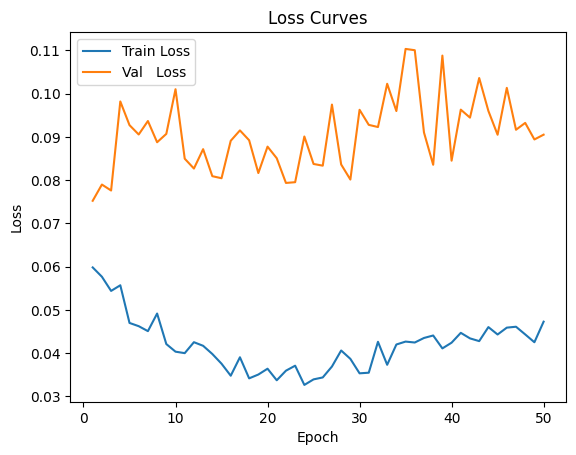

In [65]:
plt.figure()
plt.figure()
plt.plot(history.epoch, history.train_loss, label="Train Loss")
plt.plot(history.epoch, history.val_loss,   label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Loss Curves")
plt.show()


**AUROC vs. Epoch**

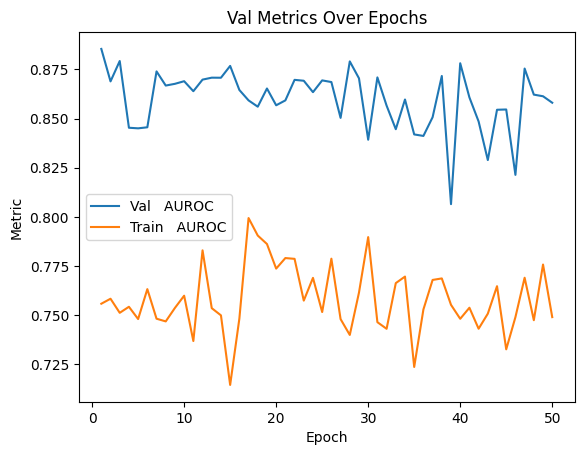

In [66]:
plt.figure()
plt.plot(history.epoch, history.val_auroc,    label="Val   AUROC")
plt.plot(history.epoch, history.train_auroc,    label="Train   AUROC")
plt.xlabel("Epoch"); plt.ylabel("Metric")
plt.legend(); plt.title("Val Metrics Over Epochs")
plt.show()


##Threshold Analysis on Final Epoch

In [67]:
def get_epoch_preds(epoch_idx, threshold=0.5):
    """
    Returns (filenames, y_true, y_prob, y_pred) for epoch `epoch_idx` (0-based),
    where y_pred is computed by thresholding y_prob.
    """
    files  = all_epoch_files[epoch_idx]
    y_true = np.array(all_epoch_true[epoch_idx])
    y_prob = np.array(all_epoch_prob[epoch_idx])
    y_pred = (y_prob >= threshold).astype(int)
    return files, y_true, y_prob, y_pred

In [68]:
best_epoch = 50
# - files:      list of validation filenames
# - y_true:     ground-truth labels (0 or 1)
# - y_prob:     predicted probabilities from the model (after sigmoid)
# - y_pred:     binary predictions using the threshold (by default,0.5)
files, y_true, y_prob, y_pred = get_epoch_preds(best_epoch - 1)


**ROC Curve with Youden Poin**

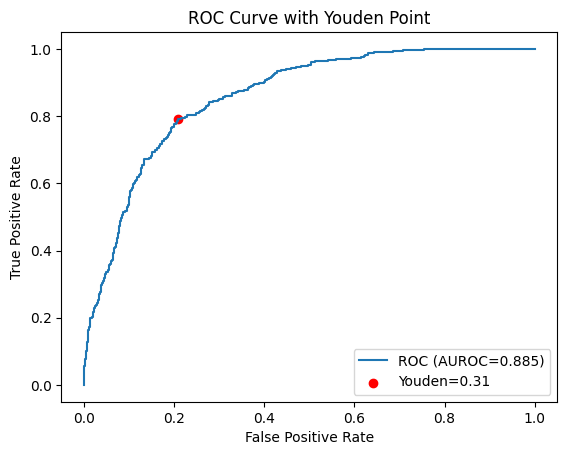

In [69]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
J = tpr - fpr
idx = J.argmax()
youden_thresh = thresholds[idx]

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUROC={history.val_auroc.max():.3f})")
plt.scatter(fpr[idx], tpr[idx], color="red", label=f"Youden={youden_thresh:.2f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.title("ROC Curve with Youden Point")
plt.show()


**Precision-Recall Curve**

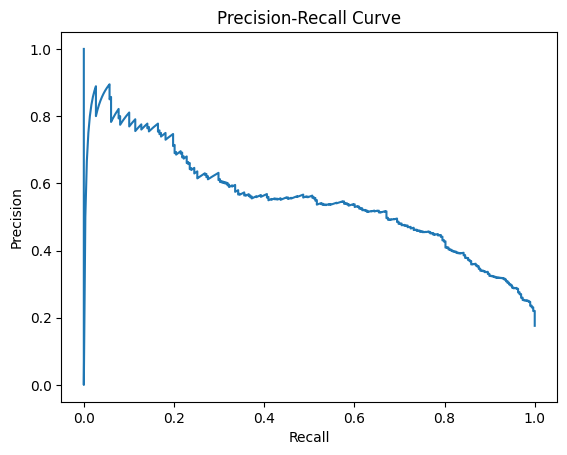

In [70]:
precision, recall, _ = precision_recall_curve(y_true, y_prob)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

**Confusion Matrices at Both Thresholds**

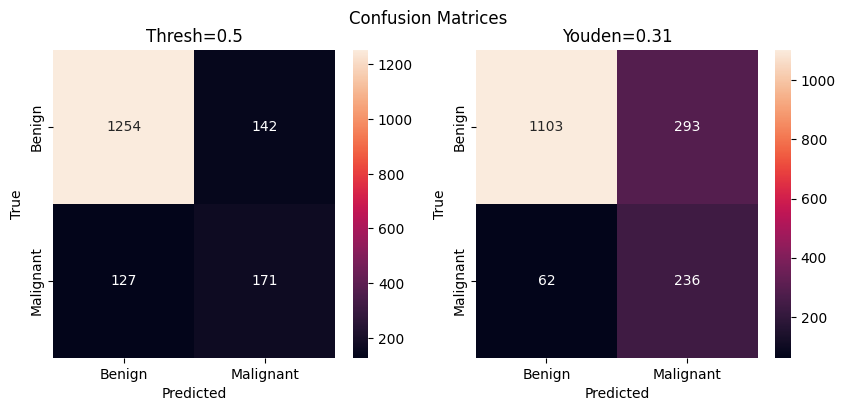

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, (thr, title) in zip(axes, [(0.5, "Thresh=0.5"), (youden_thresh, f"Youden={youden_thresh:.2f}")]):
    cm = confusion_matrix(y_true, (y_prob >= thr).astype(
      int))
    sns.heatmap(cm, annot=True, fmt="d", ax=ax,
                xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.suptitle("Confusion Matrices")
plt.show()


##Final Classification Reports

In [72]:
from sklearn.metrics import f1_score

auroc_at_x = history.val_auroc.iloc[best_epoch - 1]
print(f"AUROC at epoch {best_epoch} = {auroc_at_x:.4f}")

for thr in [0.5, youden_thresh]:
    print(f"--- Classification Report @ threshold = {thr:.2f} ---")
    y_pred_thr = (y_prob >= thr).astype(int)
    print(classification_report(y_true, y_pred_thr, target_names=["Benign","Malignant"]))

    balacc = balanced_accuracy_score(y_true, y_pred_thr)
    macro_f1 = f1_score(y_true, y_pred_thr, average="macro")

    print(f"Balanced Accuracy: {balacc:.3f}")
    print(f"Macro F1 Score:    {macro_f1:.3f}")


AUROC at epoch 50 = 0.8581
--- Classification Report @ threshold = 0.50 ---
              precision    recall  f1-score   support

      Benign       0.91      0.90      0.90      1396
   Malignant       0.55      0.57      0.56       298

    accuracy                           0.84      1694
   macro avg       0.73      0.74      0.73      1694
weighted avg       0.84      0.84      0.84      1694

Balanced Accuracy: 0.736
Macro F1 Score:    0.731
--- Classification Report @ threshold = 0.31 ---
              precision    recall  f1-score   support

      Benign       0.95      0.79      0.86      1396
   Malignant       0.45      0.79      0.57       298

    accuracy                           0.79      1694
   macro avg       0.70      0.79      0.72      1694
weighted avg       0.86      0.79      0.81      1694

Balanced Accuracy: 0.791
Macro F1 Score:    0.716


In [73]:
########################################################END

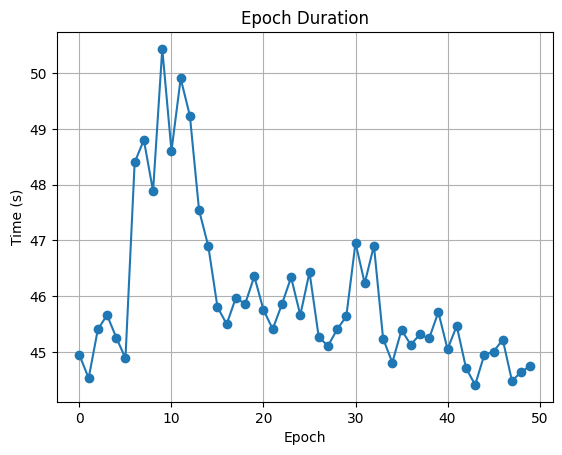

In [74]:
plt.plot(epoch_times, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Epoch Duration")
plt.grid(True)
plt.show()

In [76]:
def print_correct_diagnoses(epoch_idx, thresholds=[0.50, 0.37]):
    for thresh in thresholds:
        print(f"\n--- Threshold = {thresh:.2f} ---")
        _, y_true, _, y_pred = get_epoch_preds(epoch_idx, threshold=thresh)

        total_malignant = (y_true == 1).sum()
        total_benign    = (y_true == 0).sum()

        correct_malignant = ((y_true == 1) & (y_pred == 1)).sum()
        correct_benign    = ((y_true == 0) & (y_pred == 0)).sum()

        pct_malignant = 100 * correct_malignant / total_malignant
        pct_benign    = 100 * correct_benign    / total_benign

        print(f"Correct cancer diagnoses:     {correct_malignant}/{total_malignant} = {pct_malignant:.2f}%")
        print(f"Correct non-cancer diagnoses: {correct_benign}/{total_benign} = {pct_benign:.2f}%")

print_correct_diagnoses(epoch_idx=best_epoch-1, thresholds=[0.50, 0.31])



--- Threshold = 0.50 ---
Correct cancer diagnoses:     171/298 = 57.38%
Correct non-cancer diagnoses: 1254/1396 = 89.83%

--- Threshold = 0.31 ---
Correct cancer diagnoses:     234/298 = 78.52%
Correct non-cancer diagnoses: 1108/1396 = 79.37%


coisas que ta:

```
melhores resultados:

y=1.5 apha = 0.7
split de 30/70 para o treino de malignos
com mixup em todos menos ultimos 3 epochs


testando:
0.5 alpha em vez de 0.5 e 2 po Y
mixup e cutmix na fucncao train one epoch
```

TODO:
marcar tempos e memoria
guardar os pesos